## Campaign ROI 

In [1]:
#!pip3 install numpy --upgrade

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl


Bad key "backend.qt4" on line 43 in
/etc/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
# load the model from disk
import pickle
loaded_model = pickle.load(open('models/development_model.sav', 'rb'))

In [5]:
#loaded_model.steps

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv') 
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

In [8]:
y_pred = loaded_model.predict(X_test)

In [9]:
y_pred_proba = loaded_model.predict_proba(X_test)

In [10]:
y_pred_final =  pd.DataFrame(y_pred_proba, columns=['NoConversion', 'Conversion'])

In [11]:
y_pred_final = y_pred_final.drop('NoConversion', axis=1)

In [12]:
def predictions_threshold(y_proba, threshold):
    y_proba['pred'] = [1 if pred > threshold else 0 for pred in y_proba['Conversion']]
    return y_proba

In [13]:
y_pred = predictions_threshold(y_pred_final, 0.5)['pred'].squeeze()

In [14]:
cm = confusion_matrix(y_test, y_pred)

In [15]:
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix

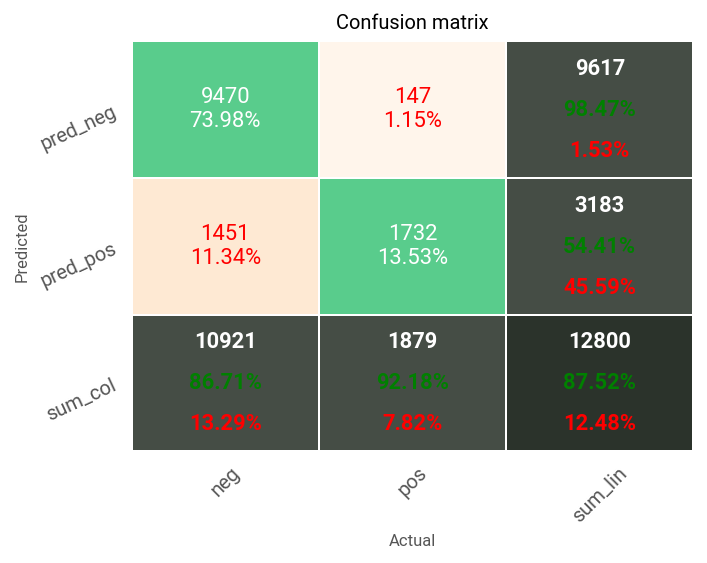

In [16]:
pretty_plot_confusion_matrix(pd.DataFrame(cm, columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']), figsize=[5,4])
plt.show()

In [17]:
def targeted_campaign_profit(cm, mrtk_unit_cost, fixed_campaign_cost, unit_revenue):
    
    #Collecting true and false positives
    fp = cm[0,1]
    tp = cm[1,1]
    
    #Calculating Revenue
    rev = tp*unit_revenue
    #Calculating Costs:
    costs = (fp+tp)*mrtk_unit_cost + fixed_campaign_cost
    #Calculating Profit:
    campaign_profit = rev - costs
    
    return campaign_profit

In [18]:
print("Estimated Targeted Campaign ROI")
targeted_campaign_profit(cm, 10, 200, 300)

Estimated Targeted Campaign ROI


487570

In [19]:
def blast_campaign_profit(y_test, mrtk_unit_cost, fixed_campaign_cost, unit_revenue):
    
    #Collecting true and false positives
    y_accepted = y_test.sum()
    y_denied = y_test.shape[0] - y_accepted
    
    #Calculating Revenue
    rev = y_accepted*unit_revenue
    #Calculating Costs:
    costs = (y_denied+y_accepted)*mrtk_unit_cost + fixed_campaign_cost
    #Calculating Profit:
    campaign_profit = rev - costs
    
    return campaign_profit[0]

In [20]:
print("Estimated Blast Campaign ROI")
blast_campaign_profit(y_test, 10, 200, 300)

Estimated Blast Campaign ROI


435500

Changing Decision Threshold

In [21]:
y_pred = predictions_threshold(y_pred_final, 0.3)['pred'].squeeze()

In [22]:
cm = confusion_matrix(y_test, y_pred)

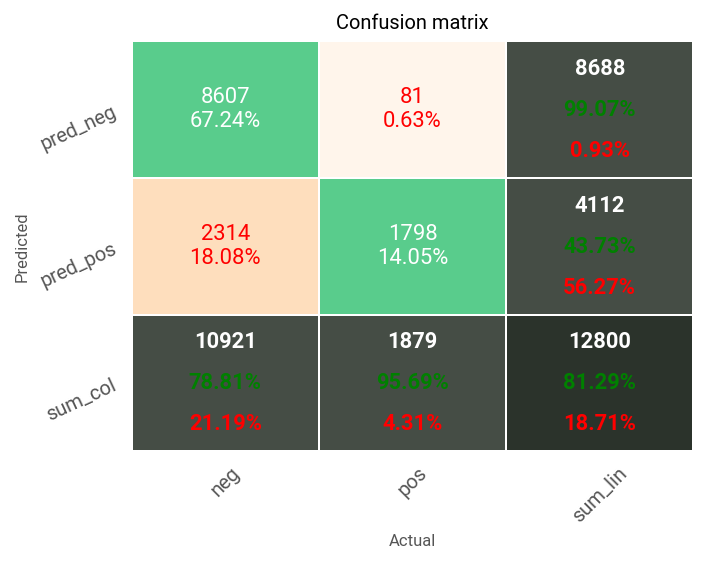

In [23]:
pretty_plot_confusion_matrix(pd.DataFrame(cm, columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']), figsize=[5,4])
plt.show()

In [24]:
print("Estimated Targeted Campaign ROI")
targeted_campaign_profit(cm, 10, 200, 300)

Estimated Targeted Campaign ROI


498080

In [25]:
print("Estimated Blast Campaign ROI")
blast_campaign_profit(y_test, 10, 200, 300)

Estimated Blast Campaign ROI


435500

In [26]:
def profit_by_threshold(y_pred_final, y_test, threshold, unit_cost, fixed_cost, unit_revenue):
    
    y_pred = predictions_threshold(y_pred_final, threshold)['pred'].squeeze()
    cm = confusion_matrix(y_test, y_pred)
    
    b_camp_profit = blast_campaign_profit(y_test, unit_cost, fixed_cost, unit_revenue)
    t_camp_profit = targeted_campaign_profit(cm, unit_cost, fixed_cost, unit_revenue) 
    
    return b_camp_profit, t_camp_profit

In [27]:
def draw_profit_curves(y_pred_final, y_test, unit_cost, fixed_cost, unit_revenue):
    
    curves_df = []
    
    for threshold in np.arange(0,1,.1):
        
        b_camp_profit, t_camp_profit = profit_by_threshold(y_pred_final, y_test, threshold, 
                                                           unit_cost, fixed_cost, unit_revenue)
        
        curves_df.append((b_camp_profit, t_camp_profit, threshold))
    
    return pd.DataFrame(curves_df, columns=['blast_profit', 'targeted_profit', 'threshold'])

In [28]:
df = draw_profit_curves(y_pred_final, y_test, 10, 5000, 300)

In [29]:
df

,blast_profit,targeted_profit,threshold
0,430700,430700,0.0
1,430700,491400,0.1
2,430700,493600,0.2
3,430700,493280,0.3
4,430700,486020,0.4
5,430700,482770,0.5
6,430700,472330,0.6
7,430700,457000,0.7
8,430700,423090,0.8
9,430700,332060,0.9


In [38]:
df.to_csv('campaign_profit.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
y_pred_final.to_csv('y_pred_final.csv', index=False)

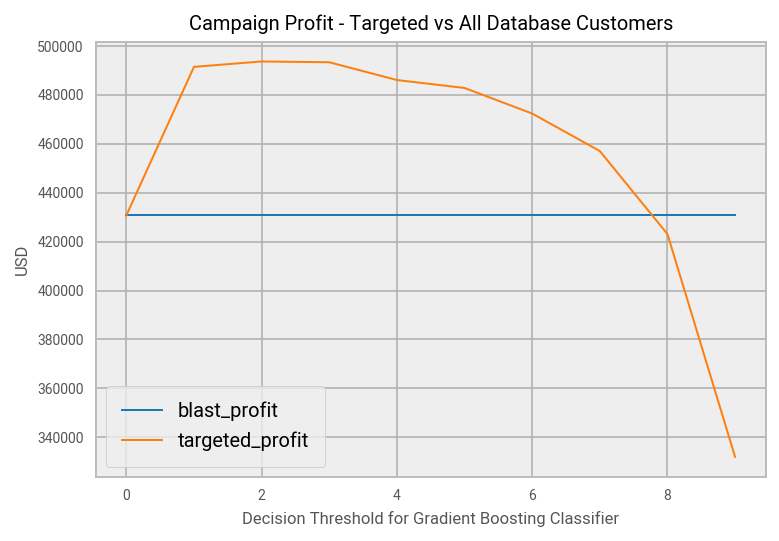

In [32]:
df[['blast_profit', 'targeted_profit']].plot(title='Campaign Profit - Targeted vs All Database Customers')
plt.xlabel('Decision Threshold for Gradient Boosting Classifier')
plt.ylabel('USD')
plt.show()

### We would pick a decision threshold such that the orange line is at its peak

### This is roughly at 0.2 
### We create a new Confusion Matrix to see what that might look like

In [33]:
y_pred = predictions_threshold(y_pred_final, 0.2)['pred'].squeeze()

In [34]:
cm = confusion_matrix(y_test, y_pred)

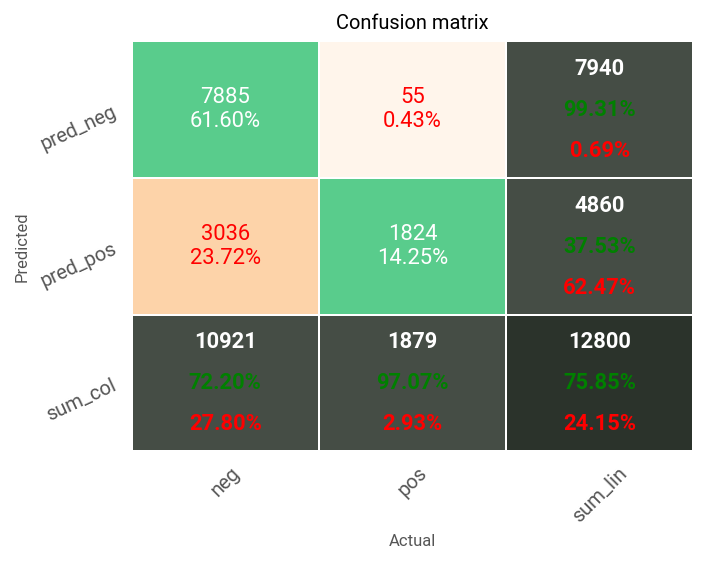

In [35]:
pretty_plot_confusion_matrix(pd.DataFrame(cm, columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']), figsize=[5,4])
plt.show()